In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
#import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Optimale Parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Interpretation
import shap
shap.initjs()


In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [3]:
df.shape

(2139, 17)

In [4]:
df.columns

Index(['Unnamed: 0', 'age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1',
       'drugs_1', 'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1',
       'hemo_1', 'race_1', 'ecog_1'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

In [6]:
df.head(5)

,age,cd40,cid,trt_1,trt_2,trt_3,homo_1,drugs_1,z30_1,gender_1,strat_2,strat_3,symptom_1,hemo_1,race_1,ecog_1
0,48,422,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,61,162,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,45,326,0,0,0,1,1,1,1,1,0,1,0,0,0,0
3,47,287,0,0,0,1,1,0,1,1,0,1,0,0,0,0
4,43,504,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [7]:
# df1-Datensatz für erste Modellrechnungen erstellen, der unveränderter, encodeder df-Datensatz kann im Verlauf aufgerufen werden
df1 = df

# Datensplitting

In [8]:
X=df1.drop(['cid'],axis=1)
y=df1['cid']

In [9]:
#from sklearn.model_selection import train_test_split
X_fintrain, X_fintest, y_fintrain, y_fintest = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=42)

print('X Train groß: {}'.format(X_fintrain.shape)) 
print('Y Train groß: {}'.format(y_fintrain.shape)) 
print('X Test final: {}'.format(X_fintest.shape)) 
print('Y Test final: {}'.format(y_fintest.shape))


X Train groß: (1711, 15)
Y Train groß: (1711,)
X Test final: (428, 15)
Y Test final: (428,)


# Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

Es werden nur die Daten für das Training normalisiert. 

Für Ausblick: In piplines können sowohl Trainings- als auch Testdaten normalisiert werden. 

## Scaler fitten

Das ist zugegeben eine unschöne Lösung. Der Scaler wird auf den Daten 1. Splits gefittet und die numerischen Features gleich transformiert.
Schöner wäre es, den Scaler auf numerische Features zu fitten und über pipelines beliebeg auf Daten mit scaler.transform() anwenden. 

In [12]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_fintrain['age'] = mscaler.fit_transform(X_fintrain['age'].to_numpy().reshape(-1,1))
X_fintrain['cd40'] = mscaler.fit_transform(X_fintrain['cd40'].to_numpy().reshape(-1,1))

# Erstellen des Validierungsdatensatzes

Der Trainingsdatensatz wird noch ein mal geteilt, um während der Trainingsphase einen Validierungsdatensatz zu haben.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_fintrain, y_fintrain, shuffle=True, test_size=0.2,random_state=42)

print('X Train klein: {}'.format(X_train.shape)) 
print('Y Train klein: {}'.format(y_train.shape)) 
print('X Validierung: {}'.format(X_test.shape)) 
print('Y Validierung: {}'.format(y_test.shape))

X Train klein: (1368, 15)
Y Train klein: (1368,)
X Validierung: (343, 15)
Y Validierung: (343,)


In [14]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

# Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wurde mittels Random_Search durchgeführt. GRID-Research und Cross-Validierung dauerte zu lange. 

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). <span style=color:green>Vorweg:</span> Es wird überlegt, die `gamma`='scale' statt dem optimierten wert zu nehmen. 

<span style=color:green>Nota bene:</span>

`C` (Regularization Parameter): Controls the trade-off between a smooth decision boundary and correctly classifying training points.

`Kernel`: Specifies the function that transforms the input data into a higher-dimensional space to make it linearly separable.

`Gamma (γ)`: Determines how far the influence of a single training example reaches in non-linear kernels like RBF.

Die Doku vom [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html).

Die Hyperparameter-Optimierung Modellbetrachtung erfolgt auf Trainingsdaten.

In [ ]:

# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf.fit(X_train1, y_train1)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(0.23233444867279784), 'penalty': 'l1'}


In [16]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=10,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search.fit(X_train1,y_train1)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [17]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train1, y_train1)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F4AF893FD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F4AF8A5640>},
                   random_state=42)

Für optimale Hyperparameter bräuchte es theoretisch keinen 2. Split für Validierungsdaten, da `RandomizedSearch` `cv` (Crossvalidierung) verwendet. Allerdings werde ich die X_test-Validierungsdaten in der Trainingsphase nach der Modellauswahl brauchen.

In [18]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


# Die Auswahl des Classifikators

In [20]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy = accuracy_score(y_test1, y_pred)
    precision = precision_score(y_test1, y_pred)
    recall = recall_score(y_test1, y_pred)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 0.00%
Trainingsdaten, Recall für RBF SVC: 0.00%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 59.09%
Trainingsdaten, Recall für Random Forest: 14.61%


### gamma = 'scale'

In [21]:
# mit gamma = 'scale'
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy = accuracy_score(y_test1, y_pred)
    precision = precision_score(y_test1, y_pred)
    recall = recall_score(y_test1, y_pred)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 50.00%
Trainingsdaten, Recall für RBF SVC: 4.49%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 59.09%
Trainingsdaten, Recall für Random Forest: 14.61%


Die Entscheidung bei EBF-SVC wäre für `gamma`= 'scale'. Allerdings ist der beste Calssifikator - anhand von Performance-Parameter - der Random Forest. So ist `gamma` nicht weiter wichtig.

<span style=color:green>Precision steigern:</span> Random Forest auf permutation importance anschauen. Die *permutation importance* gibt Auskunft darüber, wie wichtig das jeweilige Feature für genau dieses Modell ist.==> ggf. Die Daten noch ein Mal reduzieren. Die Vorauswahl spricht klar für Random Forest. Theoretisch wäre es möglich, noch in diesem Schritt auch RBF-SVC mit zu betrachten.

## Random Forest

*classification_report* fasst die Performance-Parameter des Modells im Bezug auf das Target zusammen.

Trenningsdaten, Akkuranz RF Modell: 0.7521865889212828
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       323
           1       0.13      0.60      0.22        20

    accuracy                           0.75       343
   macro avg       0.55      0.68      0.54       343
weighted avg       0.92      0.75      0.82       343



Text(0.5, 0, 'Permutation Importance RF, Trainingsdaten')

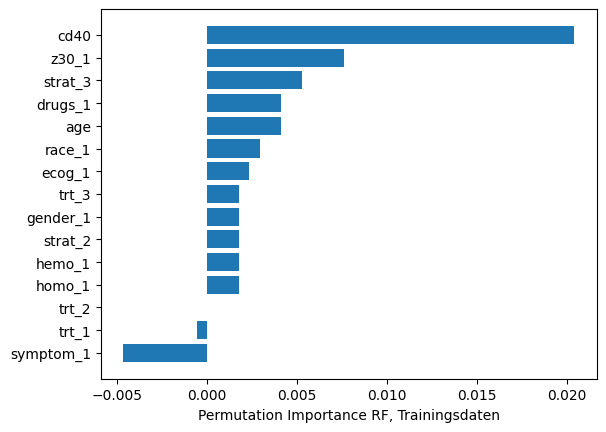

In [22]:
#rf = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
from sklearn.metrics import classification_report
best_rf.fit(X_train1, y_train1)
y_pred3 = best_rf.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred3)

print("Trenningsdaten, Akkuranz RF Modell:", accuracy)

print(classification_report(y_pred3, y_test1))

perm_importance2 = permutation_importance(best_rf, X_test1, y_test1)

feature_names2 = X_train1.columns
features = np.array(feature_names2)

sorted_idx = perm_importance2.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance2.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RF, Trainingsdaten")


A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 

<span style=color:green> Die möglichen 'low-perform' Features</span> wären nun `Treatment` (insbesondere _1 und _2), `Sexualität`, `Hemophily`und `Gender`. Auf die letzten drei kann man inhaltlich begründet (die sexluelle Orientierung/Praktiken, niedrige Heparin-Werte und Geschlecht sagen wenig für das Überleben mit HIV aus) verzichten. Aber das Studien-Treatment, die entscheidende Behandlung also, wäre schon von prädiktivem Wert. Anderseits ist *Treatment* randomisiert, d.h. er würde ggf. sich gleichmässig auf alle anderen Merkmale verteilen. EIne schwierige Entscheidung, die noch ggf. weitere explorative Statistiken verlangen würde. 

**`Sexualität`, `Hemophily`und `Gender` gehen aus der Modellierung raus.**

Außerdem:

`classification_report` für Random Forest liefert maue *Precision* <span style=color:red> für das Target = 1 (failure)</span>. Das ist ein deutlicher Hinweis auf unsymetrische Daten. Auch die Akkuranz ist mittelmässig.

<span style=color:green> Nota bene:</span> `permutation importance` zeigt unterschiedliche, Modell-spezifische Feature-Gewichtung. Daher bringt mich diese Schleife im Entscheidungsprozess nicht weiter, in der Frage - welches Modell für die Prediktion soll gewählt werden. Back to the roots: Entscheidung anhand der Performance-Parameter treffen. ==> Random Forest.

Bevor wir zu dem nächsten Schritt unwichtige Features auszusortiren übergehen, werden noch Mal die Precision und Recall in einer *Confusionsmatrix* dargestellt. SO springt die mittelmässige Leistung des Modells noch besser ins Auge. 

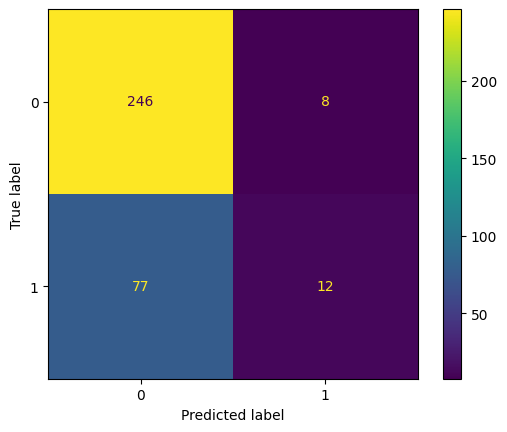

In [23]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm3 = confusion_matrix(y_test1, y_pred3)

ConfusionMatrixDisplay(cm3).plot();

In [24]:
#Accuracy im Traings- und Validierungsdatensatz
# wie gut wurde getrennt? 

print("Akkuranz Train klein: {}".format(best_rf.score(X_train1, y_train1)))
print("Akkuranz Test Validierung: {}" .format(best_rf.score(X_test1, y_test1)))

Akkuranz Train klein: 0.8194444444444444
Akkuranz Test Validierung: 0.7521865889212828


Der Unterschied von ca. 0.06 Punkten für Random Forest Akkuranz in den Trainings- und Testdaten (Validierungsdaten) ist schon groß. Das Splitting war nicht ganz optimal?

# Features-Reduktion

Nachfolgend werden die Features anhand von *feature permutation* für das Random Forest und nach inhaltlichen Überlegungen (domane Wissen) aus der weiteren Modellierung entfernt:

`Sexualität`, `Hemophily`und `Gender`.

In [25]:
X_train2=X_train.drop(["gender_1",  "hemo_1", "homo_1"],axis=1)
X_test2=X_test.drop(["gender_1",  "hemo_1", "homo_1"],axis=1)
y_train2 = y_train.copy()
y_test2 = y_test.copy()


## Hyperparameter für Random Forest

Der Gegencheck für die optimalen Hyperparamter für das Random Forest Modell für den reduzierten Datensatz wird durchgeführt.

In [26]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F4B067EF40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F4B0687D90>},
                   random_state=42)

In [27]:
best_rf3 = rand_search.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


In [28]:
#rf2 = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf3.fit(X_train2, y_train2)
y_pred3 = best_rf3.predict(X_test2)
accuracy3 = accuracy_score(y_test2, y_pred3)

print("Trenningsdaten reduziert, Akkuranz RF Modell:", accuracy3)

print(classification_report(y_pred3, y_test2))

Trenningsdaten reduziert, Akkuranz RF Modell: 0.7521865889212828
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       317
           1       0.17      0.58      0.26        26

    accuracy                           0.75       343
   macro avg       0.56      0.67      0.56       343
weighted avg       0.90      0.75      0.81       343



`classification_report` liefert eine **etwas bessere** *Precision* und *Supporter* für RF für das Target = 1 (failure).

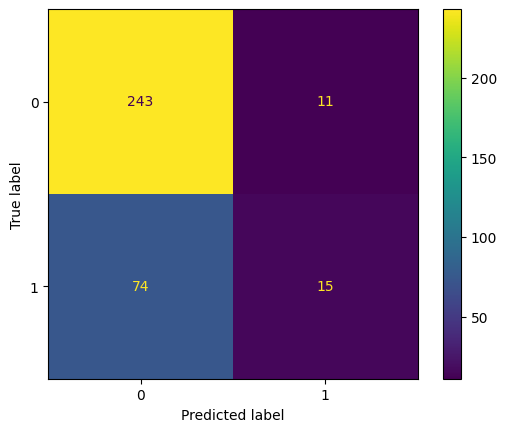

In [29]:
# Generate predictions with the best model
y_pred3 = best_rf3.predict(X_test2)

# Create the confusion matrix
cm3 = confusion_matrix(y_test2, y_pred3)

ConfusionMatrixDisplay(cm3).plot();

Text(0.5, 0, 'Permutation Importance RF, reduzierte Trainingsdaten')

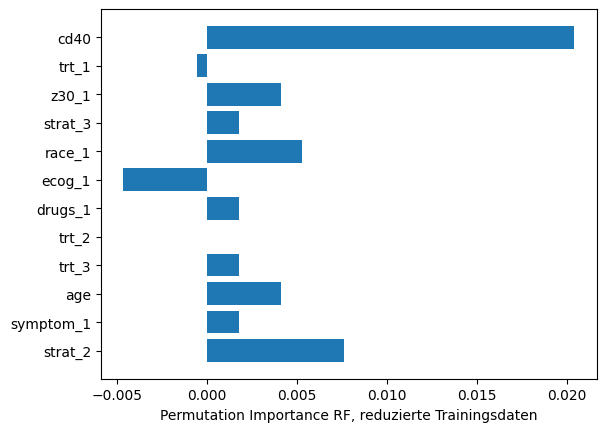

In [30]:
perm_importance3 = permutation_importance(best_rf3, X_test2, y_test2)

feature_names3 = X_train2.columns
features = np.array(feature_names3)

sorted_idx = perm_importance3.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance2.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RF, reduzierte Trainingsdaten")

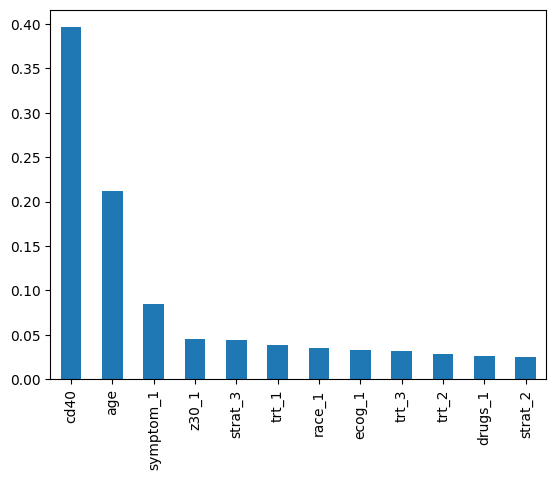

In [31]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances3 = pd.Series(best_rf3.feature_importances_, index=X_train2.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances3.plot.bar();

In [32]:
print(feature_importances3)

cd40         0.396330
age          0.211981
symptom_1    0.084966
z30_1        0.045330
strat_3      0.043763
trt_1        0.038163
race_1       0.034610
ecog_1       0.032837
trt_3        0.031437
trt_2        0.028815
drugs_1      0.026451
strat_2      0.025316
dtype: float64


# Evaluation des Modells mit Testdaten

In [34]:
X_ftrain=X_fintrain.drop(["hemo_1", "homo_1", "gender_1"],axis=1)
X_ftest=X_fintest.drop(["hemo_1", "homo_1", "gender_1"],axis=1)
y_ftrain = y_fintrain.copy()
y_ftest = y_fintest.copy()

In [35]:
#rffin = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf3.fit(X_ftrain, y_ftrain)
y_pred_fin = best_rf3.predict(X_ftest)
accuracy_fin = accuracy_score(y_ftest, y_pred_fin)

print("Testdaten, Akkuranz Random Forest:", accuracy_fin)

print(classification_report(y_pred_fin, y_ftest))

Testdaten, Akkuranz Random Forest: 0.7616822429906542
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       427
           1       0.00      0.00      0.00         1

    accuracy                           0.76       428
   macro avg       0.50      0.38      0.43       428
weighted avg       0.99      0.76      0.86       428



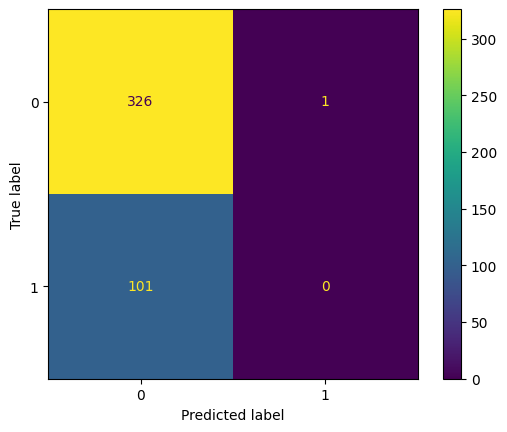

In [36]:
# Create the confusion matrix
cm_fin = confusion_matrix(y_ftest, y_pred_fin)

ConfusionMatrixDisplay(cm_fin).plot();

In [37]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist nicht groß == guter Spliting

print("Akkuranz Random Forest Train: {}".format(best_rf3.score(X_ftrain, y_ftrain)))
print("Akkuranz Random Forest Test: {}" .format(best_rf3.score(X_ftest, y_ftest)))

Akkuranz Random Forest Train: 0.8158971361776739
Akkuranz Random Forest Test: 0.7616822429906542


Der Unterschied in den Testdaten ist um 0.01 Punkte geringer.

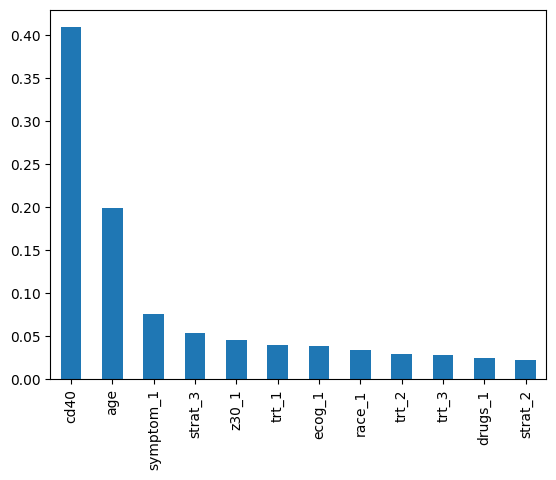

In [39]:
# Create a series containing feature importances from the model and feature names from the training data
fin_feature_importances = pd.Series(best_rf3.feature_importances_, index=X_ftest.columns).sort_values(ascending=False)

# Plot a simple bar chart
fin_feature_importances.plot.bar();

In [40]:
print(fin_feature_importances)

cd40         0.409140
age          0.198651
symptom_1    0.075160
strat_3      0.054050
z30_1        0.045203
trt_1        0.040113
ecog_1       0.038660
race_1       0.033797
trt_2        0.029674
trt_3        0.028608
drugs_1      0.025121
strat_2      0.021822
dtype: float64


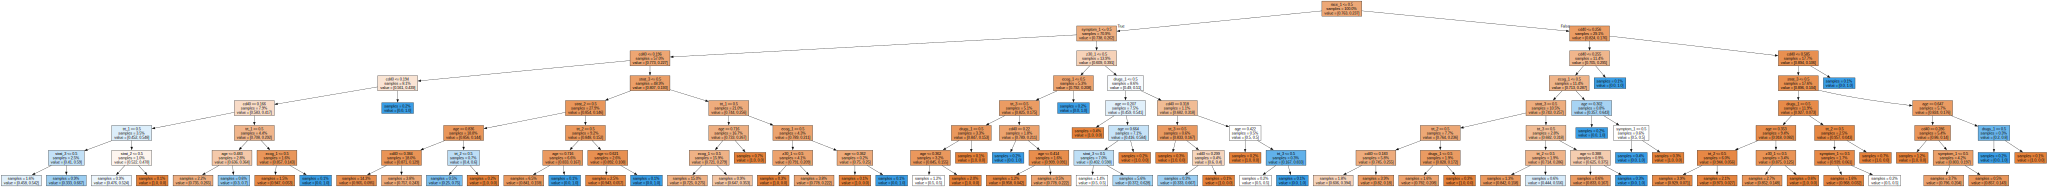

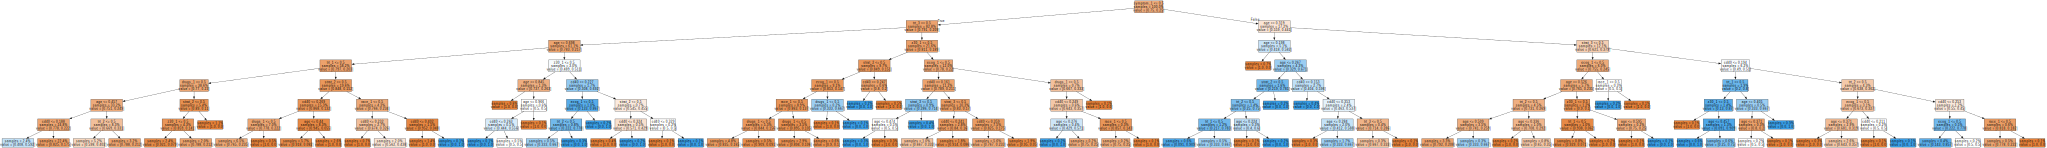

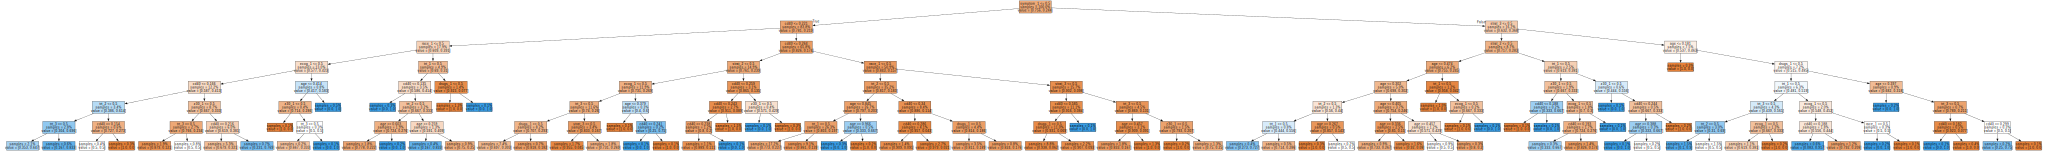

In [41]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf3.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_ftest.columns,  
                               filled=True,  
                               max_depth=7, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

# Interpretation

feature importance, Reihenfolge der Knoten, Aussagekraft der Prediction.